In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential, layers
from pandas import DataFrame
from pandas import concat
from itertools import chain
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings('ignore')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def lstm_model(source_data_set, train_x, label_y, input_epochs, input_batch_size, timesteps_out):
    model = Sequential([layers.LSTM(units=128, return_sequences=True, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])),
                       layers.LSTM(units=128, return_sequences=False),
                       layers.Dropout(0.5),
                       layers.Dense(timesteps_out, activation='linear')])
    model.compile(loss='mse', optimizer='Adam')
    # LSTM训练 input_epochs次数
    res = model.fit(train_x, label_y, epochs=input_epochs, batch_size=input_batch_size, verbose=2, shuffle=False)

    # 模型预测
    train_predict = model.predict(train_x)
    #test_data_list = list(chain(*test_data))
    train_predict_list = list(chain(*train_predict))

    plt.plot(res.history['loss'], label='train')
    plt.show()
    print(model.summary())
    plot_img(source_data_set, train_predict)
    
# 呈现原始数据，训练结果，验证结果，预测结果
def plot_img(source_data_set, train_predict):
    plt.figure(figsize=(24, 8))
    # 原始数据蓝色
    plt.plot(source_data_set, c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], c='g')
    plt.legend()
    plt.show()


    

In [3]:
# 转化为可以用于监督学习的数据
def get_train_set(data_set, timesteps_in, timesteps_out=1):
    train_data_set = np.array(data_set)
    reframed_train_data_set = np.array(series_to_supervised(train_data_set, timesteps_in, timesteps_out).values)
    print(reframed_train_data_set)
    print(reframed_train_data_set.shape)
    train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, -timesteps_out:]
    # 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
    train_x = train_x.reshape((train_x.shape[0], timesteps_in, 1))
    return train_x, train_y

"""
将时间序列数据转换为适用于监督学习的数据
给定输入、输出序列的长度
data: 观察序列
n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接到一起
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

[[9384. 9422. 9821. 9178. 9070. 9133.]
 [9422. 9821. 9178. 9070. 9133. 9251.]
 [9821. 9178. 9070. 9133. 9251. 9286.]
 [9178. 9070. 9133. 9251. 9286. 9111.]
 [9070. 9133. 9251. 9286. 9111. 9057.]
 [9133. 9251. 9286. 9111. 9057. 9018.]
 [9251. 9286. 9111. 9057. 9018. 8760.]
 [9286. 9111. 9057. 9018. 8760. 8726.]
 [9111. 9057. 9018. 8760. 8726. 8650.]
 [9057. 9018. 8760. 8726. 8650. 8589.]
 [9018. 8760. 8726. 8650. 8589. 8371.]
 [8760. 8726. 8650. 8589. 8371. 8163.]
 [8726. 8650. 8589. 8371. 8163. 8405.]
 [8650. 8589. 8371. 8163. 8405. 8792.]
 [8589. 8371. 8163. 8405. 8792. 8650.]
 [8371. 8163. 8405. 8792. 8650. 8741.]
 [8163. 8405. 8792. 8650. 8741. 8123.]
 [8405. 8792. 8650. 8741. 8123. 7697.]
 [8792. 8650. 8741. 8123. 7697. 7729.]
 [8650. 8741. 8123. 7697. 7729. 6968.]
 [8741. 8123. 7697. 7729. 6968. 7269.]
 [8123. 7697. 7729. 6968. 7269. 7033.]
 [7697. 7729. 6968. 7269. 7033. 7124.]
 [7729. 6968. 7269. 7033. 7124. 7208.]
 [6968. 7269. 7033. 7124. 7208. 7837.]
 [7269. 7033. 7124. 7208.

Epoch 131/500
56/56 - 0s - loss: 62940019.4286
Epoch 132/500
56/56 - 0s - loss: 62933150.2857
Epoch 133/500
56/56 - 0s - loss: 62923140.5714
Epoch 134/500
56/56 - 0s - loss: 62916227.4286
Epoch 135/500
56/56 - 0s - loss: 62900568.5714
Epoch 136/500
56/56 - 0s - loss: 62902539.4286
Epoch 137/500
56/56 - 0s - loss: 62905782.8571
Epoch 138/500
56/56 - 0s - loss: 62860672.5714
Epoch 139/500
56/56 - 0s - loss: 62885369.1429
Epoch 140/500
56/56 - 0s - loss: 62873408.0000
Epoch 141/500
56/56 - 0s - loss: 62844577.1429
Epoch 142/500
56/56 - 0s - loss: 62850488.0000
Epoch 143/500
56/56 - 0s - loss: 62859601.1429
Epoch 144/500
56/56 - 0s - loss: 62857626.2857
Epoch 145/500
56/56 - 0s - loss: 62828349.7143
Epoch 146/500
56/56 - 0s - loss: 62840342.8571
Epoch 147/500
56/56 - 0s - loss: 62798222.2857
Epoch 148/500
56/56 - 0s - loss: 62773912.0000
Epoch 149/500
56/56 - 0s - loss: 62811710.8571
Epoch 150/500
56/56 - 0s - loss: 62805926.2857
Epoch 151/500
56/56 - 0s - loss: 62777372.5714
Epoch 152/500

Epoch 306/500
56/56 - 0s - loss: 61521256.0000
Epoch 307/500
56/56 - 0s - loss: 61568077.7143
Epoch 308/500
56/56 - 0s - loss: 61578872.5714
Epoch 309/500
56/56 - 0s - loss: 61575392.0000
Epoch 310/500
56/56 - 0s - loss: 61546450.2857
Epoch 311/500
56/56 - 0s - loss: 61546581.7143
Epoch 312/500
56/56 - 0s - loss: 61572893.1429
Epoch 313/500
56/56 - 0s - loss: 61510749.7143
Epoch 314/500
56/56 - 0s - loss: 61555576.0000
Epoch 315/500
56/56 - 0s - loss: 61517609.1429
Epoch 316/500
56/56 - 0s - loss: 61490299.4286
Epoch 317/500
56/56 - 0s - loss: 61493996.5714
Epoch 318/500
56/56 - 0s - loss: 61478764.5714
Epoch 319/500
56/56 - 0s - loss: 61519313.7143
Epoch 320/500
56/56 - 0s - loss: 61458253.7143
Epoch 321/500
56/56 - 0s - loss: 61440331.4286
Epoch 322/500
56/56 - 0s - loss: 61438418.2857
Epoch 323/500
56/56 - 0s - loss: 61494060.0000
Epoch 324/500
56/56 - 0s - loss: 61478720.5714
Epoch 325/500
56/56 - 0s - loss: 61390980.0000
Epoch 326/500
56/56 - 0s - loss: 61413468.5714
Epoch 327/500

Epoch 481/500
56/56 - 0s - loss: 60210089.1429
Epoch 482/500
56/56 - 0s - loss: 60162087.4286
Epoch 483/500
56/56 - 0s - loss: 60157020.0000
Epoch 484/500
56/56 - 0s - loss: 60256035.4286
Epoch 485/500
56/56 - 0s - loss: 60161765.7143
Epoch 486/500
56/56 - 0s - loss: 60150392.5714
Epoch 487/500
56/56 - 0s - loss: 60248292.5714
Epoch 488/500
56/56 - 0s - loss: 60251213.7143
Epoch 489/500
56/56 - 0s - loss: 60185777.7143
Epoch 490/500
56/56 - 0s - loss: 60216538.2857
Epoch 491/500
56/56 - 0s - loss: 60093457.1429
Epoch 492/500
56/56 - 0s - loss: 60214154.8571
Epoch 493/500
56/56 - 0s - loss: 60159282.2857
Epoch 494/500
56/56 - 0s - loss: 60106778.8571
Epoch 495/500
56/56 - 0s - loss: 60113299.4286
Epoch 496/500
56/56 - 0s - loss: 60127119.4286
Epoch 497/500
56/56 - 0s - loss: 60149721.1429
Epoch 498/500
56/56 - 0s - loss: 60109201.7143
Epoch 499/500
56/56 - 0s - loss: 60122796.0000
Epoch 500/500
56/56 - 0s - loss: 60118197.7143


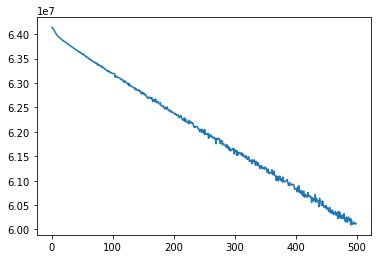

No handles with labels found to put in legend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 198,531
Trainable params: 198,531
Non-trainable params: 0
_________________________________________________________________
None


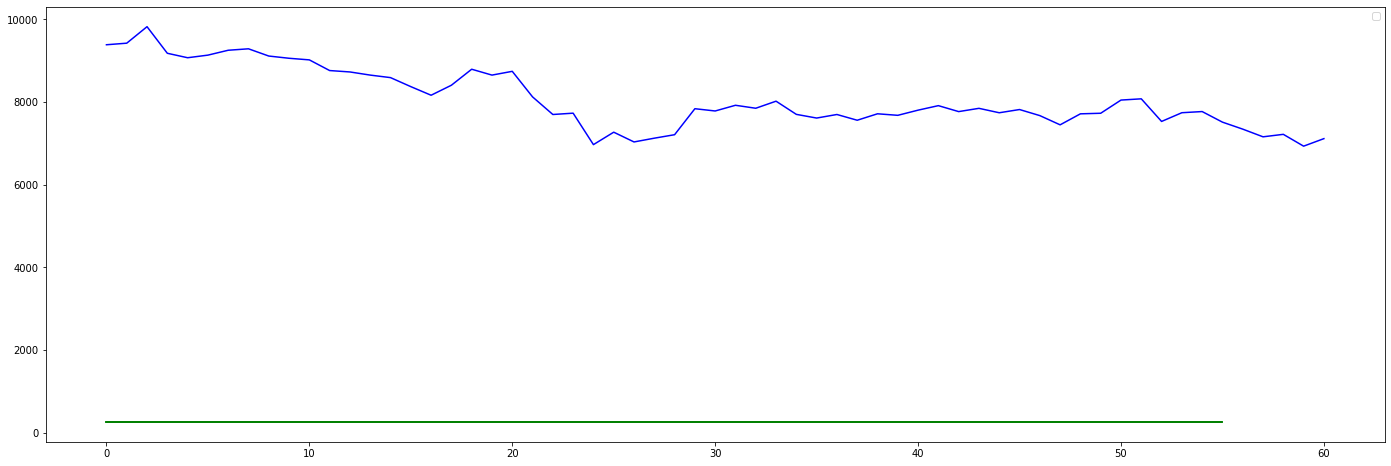

In [4]:
data = pd.read_excel("creprice_HousePriceData/区房价/广州区房价.xlsx", sheet_name="花都区")
feature = data[['价值(元/㎡)']]
# data.Timestamp = pd.to_datetime(data['时间(年-月)'])
# data.index = data.Timestamp
# 设置观测数据input(X)的步长（时间步），epochs，batch_size
timesteps_in = 3
timesteps_out = 3
epochs = 500
batch_size = 16

# 转化为可以用于监督学习的数据
train_x, label_y = get_train_set(feature, timesteps_in=timesteps_in, timesteps_out=timesteps_out)

# 使用LSTM进行训练、预测
lstm_model(feature, train_x, label_y, epochs, batch_size, timesteps_out=timesteps_out)

In [14]:
train_x

array([[[9384.],
        [9422.],
        [9821.]],

       [[9422.],
        [9821.],
        [9178.]],

       [[9821.],
        [9178.],
        [9070.]],

       [[9178.],
        [9070.],
        [9133.]],

       [[9070.],
        [9133.],
        [9251.]],

       [[9133.],
        [9251.],
        [9286.]],

       [[9251.],
        [9286.],
        [9111.]],

       [[9286.],
        [9111.],
        [9057.]],

       [[9111.],
        [9057.],
        [9018.]],

       [[9057.],
        [9018.],
        [8760.]],

       [[9018.],
        [8760.],
        [8726.]],

       [[8760.],
        [8726.],
        [8650.]],

       [[8726.],
        [8650.],
        [8589.]],

       [[8650.],
        [8589.],
        [8371.]],

       [[8589.],
        [8371.],
        [8163.]],

       [[8371.],
        [8163.],
        [8405.]],

       [[8163.],
        [8405.],
        [8792.]],

       [[8405.],
        [8792.],
        [8650.]],

       [[8792.],
        [8650.],
        [874

In [15]:
label_y

array([[9178., 9070., 9133.],
       [9070., 9133., 9251.],
       [9133., 9251., 9286.],
       [9251., 9286., 9111.],
       [9286., 9111., 9057.],
       [9111., 9057., 9018.],
       [9057., 9018., 8760.],
       [9018., 8760., 8726.],
       [8760., 8726., 8650.],
       [8726., 8650., 8589.],
       [8650., 8589., 8371.],
       [8589., 8371., 8163.],
       [8371., 8163., 8405.],
       [8163., 8405., 8792.],
       [8405., 8792., 8650.],
       [8792., 8650., 8741.],
       [8650., 8741., 8123.],
       [8741., 8123., 7697.],
       [8123., 7697., 7729.],
       [7697., 7729., 6968.],
       [7729., 6968., 7269.],
       [6968., 7269., 7033.],
       [7269., 7033., 7124.],
       [7033., 7124., 7208.],
       [7124., 7208., 7837.],
       [7208., 7837., 7782.],
       [7837., 7782., 7920.],
       [7782., 7920., 7848.],
       [7920., 7848., 8019.],
       [7848., 8019., 7700.],
       [8019., 7700., 7611.],
       [7700., 7611., 7697.],
       [7611., 7697., 7558.],
       [76